# Introduction

What problem are we trying to solve? Consider a scenario involving players who can compete against each other in pairs, resulting in one player winning and another losing. These players can be humans playing a game, such as chess. Alternatively, we might have a situation where people express their preferences by choosing one item (texts, videos, movies, pictures, songs) over another. In this case, the items themselves become the "players," with the chosen item "winning" and the other "losing".

Our goal is to be able to predict the outcomes of any two given "players" competing against each other. In other words, we want to be able to estimate the probability of any given player A to win against any other given player B, in case they are confronted to play agains each other. This question is relevant for pairs of players who have never played together as well as for those who have played together multiple times. For example, if players A and B have faced each other five times and player A won four out of those five games, we can estimate the probability of player A defeating player B as 0.8. However, we can make a much better estimate by examining player A's results against other players, as well as player B's results against other players. By considering a broader set of statistics, we can more accurately assess the strengths of both players and thus better predict the outcome when they play against each other.

# Data
To begin, we define and introduce an appropriate data structure for our analysis. We propose using a square matrix $W$, where $W_{ij}$ represents the number of wins player $j$ has over player $j$. In this matrix, the $i$-th row contains all the wins of player $i$, and the $j$-th column contains all the losses of player $j$. We will refer to this as the wins matrix.

# Model
We start with the following model. We assume that each player can be characterized by a single number, which we will refer to as strength, score, or index. Additionally, we assume that the probability of a given player winning against another one is entirely determined by their scores or, more specifically, by the difference between their scores. This implies that if the scores of two players are equal (the difference between their scores is zero) the two players are equally strong. Consequently, the probability of one player winning against another one is 0.5. As the difference between the scores increases, the probability of the first player winning over the second approaches 1.0. On the other hand, as the difference becomes negative, the probability of the first player winning drops below 0.5 (the first player loses more frequently). As the difference continues to decrease, the probability of winning approaches zero. One of the functions that has the described properties is sigmoid function. It can be defined either via exponents or hyperbolic tangent:

$$
\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{1 + e^{-x}} = \frac{1}{2} \tanh(\frac{x}{2}) + \frac{1}{2}
$$

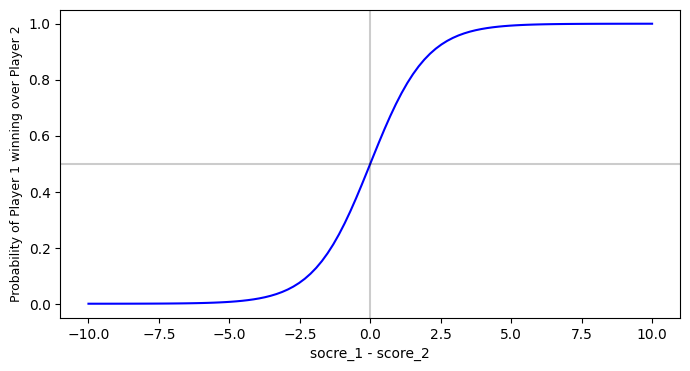

In [46]:
from scipy.special import expit
import matplotlib.pyplot as plt

x = np.linspace(-10.0, 10.0, 100)
y = expit(x)

plt.figure(figsize = (8,4))
plt.xlabel('socre_1 - score_2')
plt.ylabel('Probability of Player 1 winning over Player 2', fontsize=9)
plt.plot(x, y, color = 'b')
plt.axhline(0.5, color = 'k', alpha = 0.2)
plt.axvline(0.0, color = 'k', alpha = 0.2)
plt.show()

# Maximum Likelihood Estimation

In this section, we connect our probabilistic model to our observed data. The core concept is that for a given model parameters (represented by a vector of players' scores), we aim to calculate the probability of observing our dataset (the wins matrix). Once we establish this relationship, we can initiate a search for the optimal scores that maximize the probability of our observed dataset. This approach is known as maximum likelihood estimation (MLE).

Calculating the probability of the observed wins matrix is quite straightforward. We loop over all elements of the win matrix, where each element contains the number of wins. For each win, we can calculate its probability using our probabilistic model. Since all games and their outcomes are independent events, we multiply all these probabilities to get the combined probability of the win matrix. This product gives us the likelihood of observing the given dataset under our model.
$$
p = \prod_{i,j} \sigma(s_i - s_j)^{w_{ij}}
$$
After taking the logarithm of the above expression, we get:
$$
\log(p) = \sum_{i,j} w_{ij} \cdot \log[\sigma(s_i - s_j)]
$$
Logarithm of sigmoid can be expressed as follows:
$$
\log[\sigma(x)] = -\log(1 + e^{-x})
$$
Therefore we can write our expression for negative log likelihood as follows. 
$$
L = -\log(p) = \sum_{i,j} w_{ij} \log[1 + \exp(s_j - s_i)]
$$


In [90]:
import numpy as np

def negative_log_likelihood(ratings, wins_matrix):
    diffs = ratings[:, np.newaxis] - ratings[np.newaxis, :]
    #neg_log_probs = -np.log(expit(diffs))
    neg_log_probs = np.logaddexp(0.0, -diffs)
    n_games = np.sum(wins_matrix)
    return np.nansum(wins_matrix * neg_log_probs) / n_games

In [91]:
wins_matrix = np.random.randint(0, 5, (7,7))
np.fill_diagonal(wins_matrix, 0)

ratings = np.random.normal(size = 7)

In [92]:
negative_log_likelihood(ratings, wins_matrix)

0.8917029795588096